### Overview
This notebook import the annotation results generated by **SCINA** and include it to the originally unannotated scRNA-seq (previously, the Query file). 

The now annotated scRNA-seq will be converted to a format suitable to be used in CIBERSORTx [3]. 

**This notebook is written in Python.**

In [1]:
#Libraries and global settings
import scanpy as sc
import pandas as pd
%matplotlib inline 

i_randomstate=4 #for reproducibility

### Steps performed

1. Import the unannotated scRNA-seq

2. Import the annotation results from SCINA

3. Merge the annotation results to the unannotated scRNA-seq 
- (1) including "unassigned" group
- (2) excluding "unassigned" group

4. Visualize annotation results 
- (1) including "unassigned" group
- (2) excluding "unassigned" group

5. Convert merged scRNA-seq to a format required by CIBERSORTx 

6. Export data

#### Import the unannotated scRNA-seq

In [2]:
#Import unannotated scRNA-seq 
path ="../../data/demo_public/input/AllenBrain_unannotated.h5ad"
adata = sc.read(path, cache=True)
adata

#Extract list
l_adata_cellID = adata.obs_names.to_list()

#Create temporary dataframe 
df_adata = pd.DataFrame({'cellID':l_adata_cellID})
df_adata.head()

,cellID
0,TGCCAAATCAAAGACA-L8TX_190312_01_C01
1,TTGTAGGCATGAACCT-L8TX_190312_01_E01
2,AGAATAGTCTGGAGCC-L8TX_180907_01_H11
3,AGATCTGAGCAGGCTA-L8TX_180907_01_F11
4,TTGGAACCAGGATTGG-L8TX_180907_01_G11


#### Import the annotation results from SCINA

In [3]:
#Import annotation result
path_csv = "../../data/demo_public/output/scina_annotation.csv"
df_annotation = pd.read_csv(path_csv)

#SCINA changes "-" to ".". Change them back to "-"
temp_scina_cellID = df_annotation["cellID"].tolist()
l_scina_cellID = [samplename.replace(".", "-") if '.' in samplename else samplename for samplename in temp_scina_cellID]

#Change "Gabaergic" to "GABAergic"; change "unknown" to "unassigned"; change "Non.Neuronal" to "Non-Neuronal"
l_scina_celltype = df_annotation["annotation"].tolist()
l_scina_celltype = [celltype.replace("Gabaergic", "GABAergic") if 'Gabaergic' in celltype else celltype for celltype in l_scina_celltype]
l_scina_celltype = [celltype.replace("unknown", "unassigned") if 'unknown' in celltype else celltype for celltype in l_scina_celltype]
l_scina_celltype = [celltype.replace(".", "-") if '.' in celltype else celltype for celltype in l_scina_celltype]

#Create temporary dataframe
df_result = pd.DataFrame({'cellID':l_scina_cellID,'annotation':l_scina_celltype})
df_result.head()

,cellID,annotation
0,TGCCAAATCAAAGACA-L8TX_190312_01_C01,Glutamatergic
1,TTGTAGGCATGAACCT-L8TX_190312_01_E01,Non-Neuronal
2,AGAATAGTCTGGAGCC-L8TX_180907_01_H11,Glutamatergic
3,AGATCTGAGCAGGCTA-L8TX_180907_01_F11,GABAergic
4,TTGGAACCAGGATTGG-L8TX_180907_01_G11,Glutamatergic


#### Merge the annotation results to the unannotated scRNA-seq (1) - including "unassigned" group

In [4]:
#Merge to adata dataframe, to get the annotation in the correct order
df_adata = df_adata.merge(df_result, on=['cellID'], how='left').fillna("NA")

#Write to adata
adata.obs["annotation"]=df_adata["annotation"].to_list()
adata

#Export adata (this adata file has all the annotation categories including "unassigned")
#Uncomment the following 2 lines to export the adata
# path = "../../data/demo_public/output/annotated_incl_unassigned.h5ad"
# adata.write(filename=path)
adata.obs["annotation"].unique()

array(['Glutamatergic', 'Non-Neuronal', 'GABAergic', 'unassigned'],
      dtype=object)

#### Merge the annotation results to the unannotated scRNA-seq (2) - excluding "unassigned" group

In [5]:
#Remove "unassigned" cells
adata_subset = adata[adata.obs["annotation"]!="unassigned"]

#Export data (this adata has all but "unassigned" cells)
#Uncomment the following 2 lines to export the adata
# path = "../../data/demo_public/output/annotated_excl_unassigned.h5ad"
# adata_subset.write(filename=path)
adata_subset.obs["annotation"].unique()

array(['Glutamatergic', 'Non-Neuronal', 'GABAergic'], dtype=object)

#### Visualize annotation results (1) - including "unassigned group"

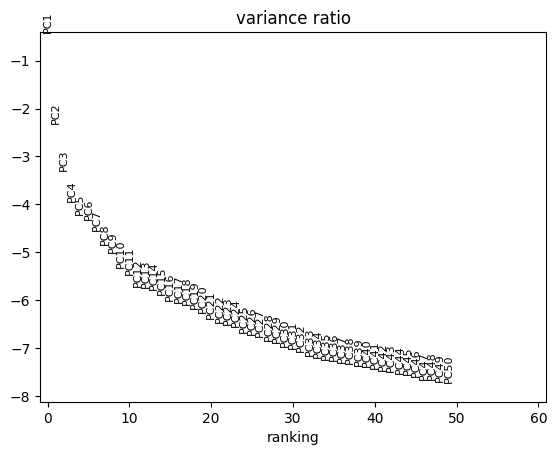

/home/chiacmm/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


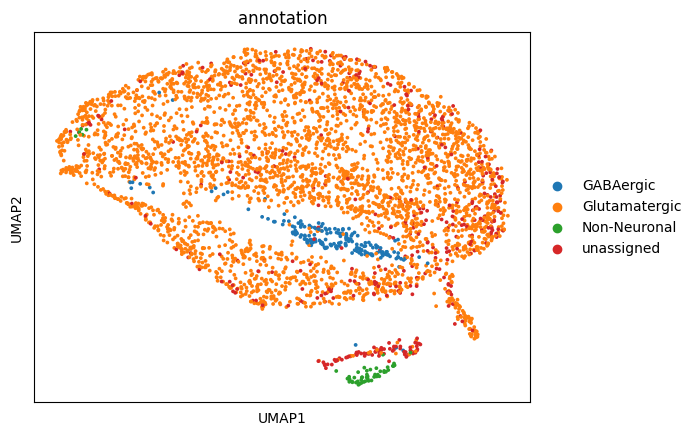

In [6]:
#All categories
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=60)
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=50, random_state=i_randomstate)
sc.tl.umap(adata, min_dist=0.4, random_state=i_randomstate)
sc.pl.umap(adata, color="annotation")

#### Visualize annotation results (2) - excluding "unassigned group"

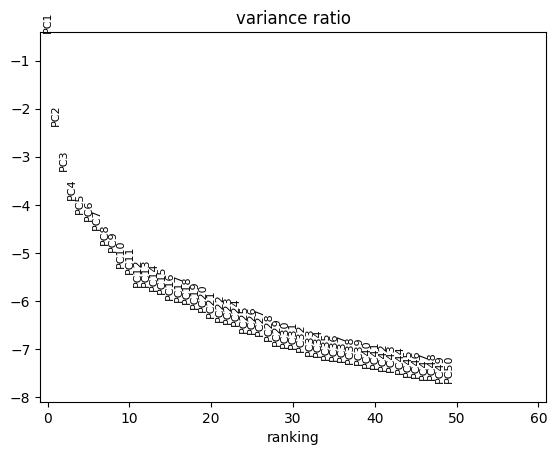

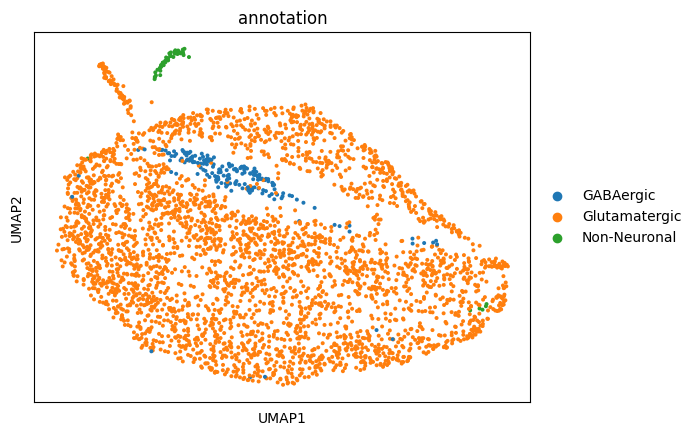

In [7]:
#All categories except for "unassigned"
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_subset, log=True, n_pcs=60)
sc.pp.neighbors(adata_subset, n_neighbors=40, n_pcs=50, random_state=i_randomstate)
sc.tl.umap(adata_subset, min_dist=0.4, random_state=i_randomstate)
sc.pl.umap(adata_subset, color="annotation")

#### Convert merged scRNA-seq to a format required by CIBERSORTx [3]

(Adapted from https://cibersortx.stanford.edu/tutorial.php)  

_CIBERSORTx will automatically normalize the input data such that the sum of all normalized reads are the same for each transcriptome._ 
_If a gene length-normalized expression matrix is provided (e.g., RPKM), then the signature matrix will be in TPM (transcripts per million)._
_If a count matrix is provided, the signature matrix will be in CPM (counts per million)._
_Regardless of the input, the signature matrix and mixture files should be represented in the same normalization space._

In [8]:
#Convert adata_subset to Reference
#Extract gene names and annotation
l_genes_filtered = adata_subset.var_names.to_list()
l_annotation_filtered = adata_subset.obs["annotation"].to_list()

#Extract the expression matrix
d_adata_X = adata_subset.X

#Create dataframe
#Outcome: genes x cell_types
df_exprs_celltype = pd.DataFrame(d_adata_X, index = l_annotation_filtered, columns=l_genes_filtered)
df_exprs_celltype_t = df_exprs_celltype.transpose()
df_exprs_celltype_t.head()

,Glutamatergic,Non-Neuronal,Glutamatergic,GABAergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,...,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Non-Neuronal
Xkr4,1.0,0.0,4.0,3.0,3.0,2.0,4.0,10.0,7.0,1.0,...,5.0,9.0,3.0,6.0,4.0,3.0,3.0,15.0,5.0,0.0
Gm1992,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Export data

In [9]:
#Write data
path = "../../data/demo_public/output/cibersortx_reference_scina.txt"
df_exprs_celltype_t.to_csv(path, sep='\t', chunksize=500)

##### Reference
1. Chia, C. M., Roig Adam, A., & Moro, A. (2022). *In silico* multiple single-subject neural tissue screening using deconvolution on pseudo-bulk RNA-seq - a prototype. Bioinformatics and Systems Biology joint degree program. Vrije Universiteit Amsterdam and University of Amsterdam. 

2. Allen Institute for Brain Science (2004). Allen Mouse Brain Atlas, Mouse Whole Cortex and Hippocampus 10x. Available from mouse.brain-map.org. Allen Institute for Brain Science (2011).

3. Newman, A. M., Liu, C. L., Green, M. R., Gentles, A. J., Feng, W., Xu, Y., Hoang, C. D., Diehn, M., & Alizadeh, A. A. (2015). Robust enumeration of cell subsets from tissue expression profiles. Nature methods, 12(5), 453–457. https://doi.org/10.1038/nmeth.3337